In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import regularizers
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from keras import backend as K
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

2023-05-23 06:30:34.503836: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# configure Keras to use GPU
tf.config.experimental.set_visible_devices([], 'GPU')

# Load the dataset
df = pd.read_csv("paysim.csv")


In [3]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [4]:
# Drop irrelevant columns
df = df.drop(['nameOrig', 'nameDest'], axis=1)

# Encode categorical features
df['type'] = df['type'].replace({'CASH_OUT': 0, 'TRANSFER': 1, 'PAYMENT': 2, 'DEBIT': 3, 'CASH_IN': 4})

# Standardize the features
scaler = StandardScaler()
df[['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']] = scaler.fit_transform(df[['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']])

# Split the dataset into features and target
X = df.drop(['isFraud'], axis=1)
y = df['isFraud']

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Create a Contractive Autoencoder to generate synthetic fraud data
input_dim = X_train.shape[1]
encoding_dim = int(input_dim / 2)

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='sigmoid')(decoder)

# Define the Contractive loss function
def contractive_loss(y_true, y_pred):
    mse = tf.keras.losses.mean_squared_error(y_true, y_pred)
    w = 1e-4 # weight given to the jacobian regularizer
    contractive_reg = K.sum(K.square(K.gradients(y_pred, encoder)[0]), axis=1)
    return mse + w * contractive_reg

autoencoder = Model(inputs=input_layer, outputs=decoder)

# Train the autoencoder on normal transactions
X_normal = X_train[y_train == 0]
X_normal_train, X_normal_test = train_test_split(X_normal, test_size=0.2, random_state=42)

autoencoder.compile(optimizer='adam', loss=contractive_loss)
history = autoencoder.fit(X_normal_train, X_normal_train, epochs=100, batch_size=32, validation_data=(X_normal_test, X_normal_test))

# Generate synthetic fraud transactions using the trained autoencoder
X_fraud = X_train[y_train == 1]
synthetic_fraud = autoencoder.predict(X_fraud)

noise_factor = 0.2
encoded_normal_noisy = synthetic_fraud + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=synthetic_fraud.shape)
synthetic_fraud_data = autoencoder.predict(encoded_normal_noisy)

# Combine the synthetic fraud transactions with the original fraud transactions
X_fraud = np.vstack((X_fraud, synthetic_fraud_data))

# Combine the normal transactions with the fraud transactions
X_balanced = np.vstack((X_normal, X_fraud))
y_balanced = np.hstack((np.zeros(X_normal.shape[0]), np.ones(X_fraud.shape[0])))

Train on 4066802 samples, validate on 1016701 samples
Epoch 1/100
   6176/4066802 [..............................] - ETA: 4:02 - loss: 1.2643  

2023-05-23 06:30:50.745399: W tensorflow/c/c_api.cc:300] Operation '{name:'training/Adam/dense_3/bias/v/Assign' id:411 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_3/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_3/bias/v, training/Adam/dense_3/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


4065728/4066802 [============================>.] - ETA: 0s - loss: 0.8651

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-05-23 06:31:55.305623: W tensorflow/c/c_api.cc:300] Operation '{name:'loss/AddN' id:146 op device:{requested: '', assigned: ''} def:{{{node loss/AddN}} = AddN[N=2, T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul, dense/ActivityRegularizer/truediv)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


4066802/4066802 [==============================] - 74s 18us/sample - loss: 0.8651 - val_loss: 0.8089
Epoch 2/100
4066802/4066802 [==============================] - 74s 18us/sample - loss: 0.8326 - val_loss: 0.8053
Epoch 3/100
4066802/4066802 [==============================] - 74s 18us/sample - loss: 0.8299 - val_loss: 0.8036
Epoch 4/100
4066802/4066802 [==============================] - 74s 18us/sample - loss: 0.8290 - val_loss: 0.8034
Epoch 5/100
4066802/4066802 [==============================] - 74s 18us/sample - loss: 0.8286 - val_loss: 0.8026
Epoch 6/100
4066802/4066802 [==============================] - 74s 18us/sample - loss: 0.8282 - val_loss: 0.8019
Epoch 7/100
4066802/4066802 [==============================] - 74s 18us/sample - loss: 0.8277 - val_loss: 0.8016
Epoch 8/100
4066802/4066802 [==============================] - 74s 18us/sample - loss: 0.8273 - val_loss: 0.8011
Epoch 9/100
4066802/4066802 [==============================] - 74s 18us/sample - loss: 0.8270 - val_loss: 0.

4066802/4066802 [==============================] - 73s 18us/sample - loss: 0.8250 - val_loss: 0.7994
Epoch 74/100
4066802/4066802 [==============================] - 73s 18us/sample - loss: 0.8250 - val_loss: 0.7991
Epoch 75/100
4066802/4066802 [==============================] - 73s 18us/sample - loss: 0.8250 - val_loss: 0.7991
Epoch 76/100
4066802/4066802 [==============================] - 73s 18us/sample - loss: 0.8250 - val_loss: 0.7993
Epoch 77/100
4066802/4066802 [==============================] - 73s 18us/sample - loss: 0.8250 - val_loss: 0.7991
Epoch 78/100
4066802/4066802 [==============================] - 73s 18us/sample - loss: 0.8249 - val_loss: 0.7991
Epoch 79/100
4066802/4066802 [==============================] - 73s 18us/sample - loss: 0.8249 - val_loss: 0.7991
Epoch 80/100
4066802/4066802 [==============================] - 73s 18us/sample - loss: 0.8250 - val_loss: 0.7992
Epoch 81/100
4066802/4066802 [==============================] - 73s 18us/sample - loss: 0.8250 - val_

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-05-23 09:21:45.153543: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_3/Sigmoid' id:110 op device:{requested: '', assigned: ''} def:{{{node dense_3/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_3/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [6]:
# Apply SMOTE Oversampling to balance the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_balanced, y_balanced)

In [7]:
# Fit the random forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier(random_state=42)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Accuracy: 0.9992471654758575
Confusion matrix:
 [[1270010     894]
 [     64    1556]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.64      0.96      0.76      1620

    accuracy                           1.00   1272524
   macro avg       0.82      0.98      0.88   1272524
weighted avg       1.00      1.00      1.00   1272524



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


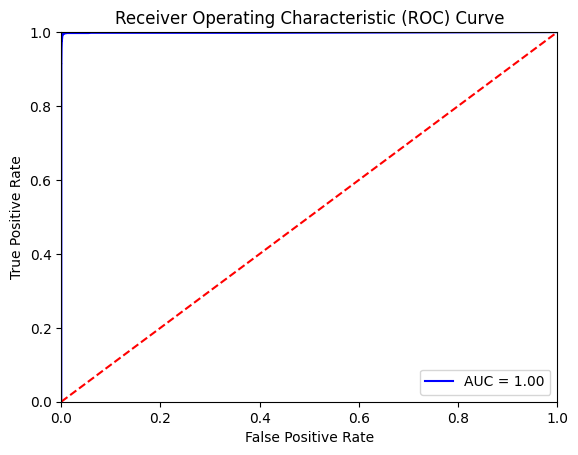

In [8]:
# Make predictions on the test set
y_pred = rf.predict(X_test)

# Compute the accuracy and confusion matrix
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('Accuracy:', accuracy)
print('Confusion matrix:\n', cm)

from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report, roc_curve, auc, accuracy_score, f1_score, precision_score, recall_score, auc, matthews_corrcoef, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

print(classification_report(y_test, y_pred))

y_pred_proba = rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc = 'lower right')
plt.show()

Accuracy: 0.999247
F1-score:  0.7646191646191646
Precision:  0.6351020408163265
Recall:  0.9604938271604938
Specificity:  0.9992965637058346
Sensitivity:  0.9604938271604938
AUC:  0.9985920707612577
Matthews correlation coefficient: 0.7807153587725953


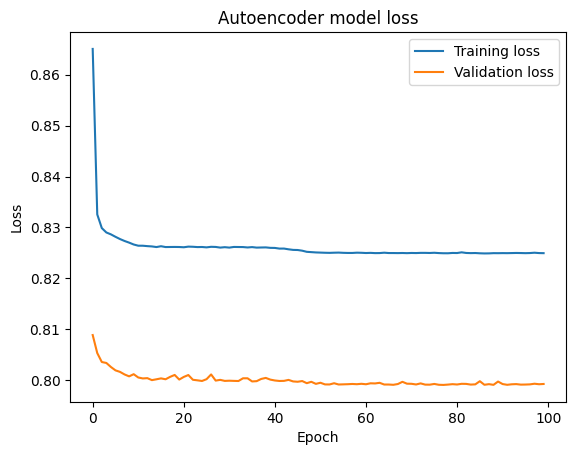

In [9]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn+fp)
sensitivity = recall
auc = roc_auc_score(y_test, y_pred_proba)

print("Accuracy: %f" % accuracy)
print("F1-score: ", f1)
print("Precision: ", precision)
print("Recall: ", recall)
print("Specificity: ", specificity)
print("Sensitivity: ", sensitivity)
print("AUC: ", auc)

mcc = matthews_corrcoef(y_test, y_pred)

print("Matthews correlation coefficient:", mcc)

# plot the loss graph
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Autoencoder model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [10]:
##

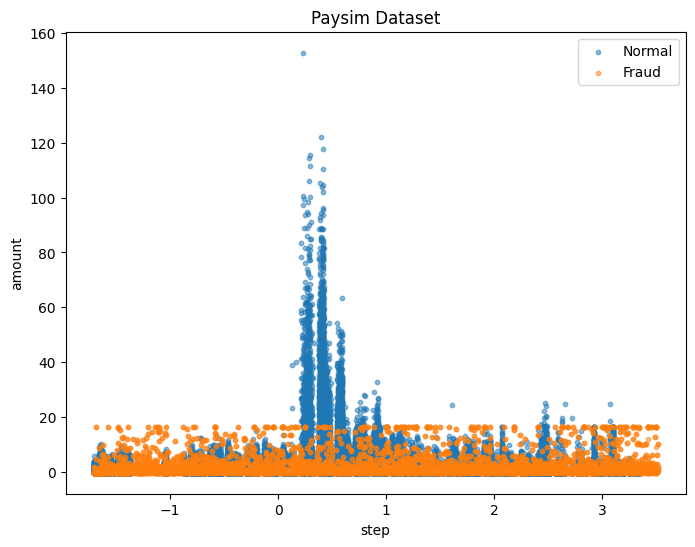

In [11]:
# Separate the normal and fraud data
normal_data = df[df['isFraud'] == 0]
fraud_data = df[df['isFraud'] == 1]

# Plotting the point distribution
plt.figure(figsize=(8, 6))
plt.title("Paysim Dataset")
plt.scatter(normal_data['step'], normal_data['amount'], label='Normal', s=10, alpha=0.5)
plt.scatter(fraud_data['step'], fraud_data['amount'], label='Fraud', s=10, alpha=0.5)
plt.xlabel("step")
plt.ylabel("amount")
plt.legend()
plt.show()

In [12]:
df1 = np.column_stack([X_train_balanced, y_train_balanced])
df2 = np.column_stack([X_test, y_test])

In [13]:
df3 = np.vstack([df1, df2])

In [14]:
df4 = pd.DataFrame(df3, columns = ['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 
                                   'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud', 'isFraud'])

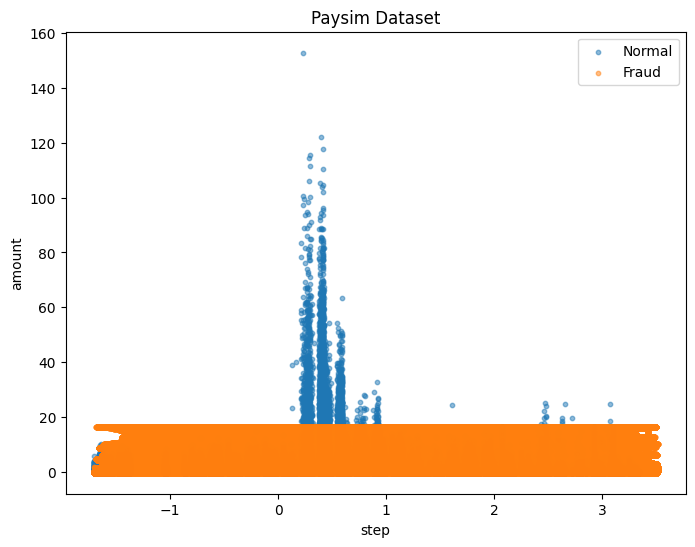

In [15]:
# Separate the normal and fraud data
normal_data = df4[df4['isFraud'] == 0]
fraud_data = df4[df4['isFraud'] == 1]

# Plotting the point distribution
plt.figure(figsize=(8, 6))
plt.title("Paysim Dataset")
plt.scatter(normal_data['step'], normal_data['amount'], label='Normal', s=10, alpha=0.5)
plt.scatter(fraud_data['step'], fraud_data['amount'], label='Fraud', s=10, alpha=0.5)
plt.xlabel("step")
plt.ylabel("amount")
plt.legend()
plt.show()